In [7]:
from pyDOE import lhs
import numpy as np
import pandas as pd

# Define problem
problem = {
    'num_vars': 7,
    'names': ['beta', 'gamma', 'sigma', 'delta', 'mu', 'lambda', 'psi'],
    'bounds': [
        [0, 0.1],  # beta
        [0, 0.1],  # gamma
        [0, 0.2],  # sigma
        [0, 0.1],  # delta
        [0, 0.1],  # mu
        [0, 1],    # lambda
        [0, 0.1]   # psi
    ]
}

# Sampling
N = 2500  # number of samples
lhs_samples = lhs(problem['num_vars'], samples=N)

# Scale to parameter bounds
bounds = np.array(problem['bounds'])
lower_bounds = bounds[:, 0]
upper_bounds = bounds[:, 1]
scaled_samples = lower_bounds + (upper_bounds - lower_bounds) * lhs_samples

# Save to CSV for MATLAB
param_df = pd.DataFrame(scaled_samples, columns=problem['names'])
param_df.to_csv("lhs_params.csv", index=False, header=False)


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('lhs_results.csv', header=None)
data.columns = ['beta', 'gamma', 'sigma', 'delta', 'mu', 'lambda', 'psi', 'cum_As', 'cum_V']

# Drop rows with NaNs
data_clean = data.dropna()

# Extract inputs and outputs
X = data_clean[['beta', 'gamma', 'sigma', 'delta', 'mu', 'lambda', 'psi']]
Y1 = data_clean['cum_As']
Y2 = data_clean['cum_V']

# Rank-transform inputs and outputs
X_ranked = X.rank()
Y1_ranked = Y1.rank()
Y2_ranked = Y2.rank()

# Compute PRCC using Spearman correlation
def prcc(X_ranked, Y_ranked):
    n_params = X_ranked.shape[1]
    prcc_vals = []
    p_vals = []

    for i in range(n_params):
        Xi = X_ranked.iloc[:, i]
        X_others = X_ranked.drop(Xi.name, axis=1)

        # Regress Xi and Y on other parameters
        from sklearn.linear_model import LinearRegression

        reg_Xi = LinearRegression().fit(X_others, Xi)
        reg_Y  = LinearRegression().fit(X_others, Y_ranked)

        # Get residuals
        res_Xi = Xi - reg_Xi.predict(X_others)
        res_Y  = Y_ranked - reg_Y.predict(X_others)

        # Spearman correlation between residuals
        r, p = spearmanr(res_Xi, res_Y)
        prcc_vals.append(r)
        p_vals.append(p)

    return np.array(prcc_vals), np.array(p_vals)

# PRCC for cum_As
prcc_as, p_as = prcc(X_ranked, Y1_ranked)

# PRCC for cum_V
prcc_v, p_v = prcc(X_ranked, Y2_ranked)

# Display results
param_names = X.columns.tolist()
df_prcc = pd.DataFrame({
    'Parameter': param_names,
    'PRCC_cum_As': prcc_as,
    'p_val_cum_As': p_as,
    'PRCC_cum_V': prcc_v,
    'p_val_cum_V': p_v
})

print(df_prcc)


  Parameter  PRCC_cum_As  p_val_cum_As  PRCC_cum_V   p_val_cum_V
0      beta     0.091734  4.346730e-06    0.113323  1.334359e-08
1     gamma    -0.077212  1.113505e-04   -0.094184  2.389594e-06
2     sigma     0.115863  6.253293e-09    0.141493  1.186720e-12
3     delta     0.808557  0.000000e+00    0.017817  3.732148e-01
4        mu    -0.802003  0.000000e+00    0.016989  3.958436e-01
5    lambda    -0.981987  0.000000e+00   -0.048106  1.615169e-02
6       psi     0.215874  9.530770e-28   -0.985919  0.000000e+00


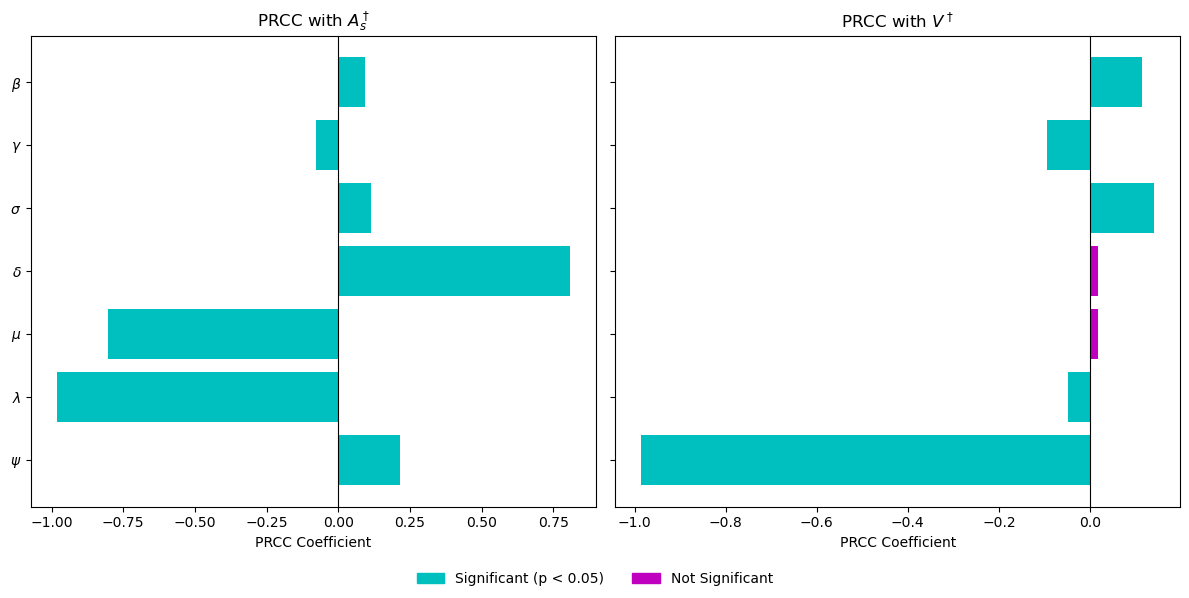

In [9]:
import matplotlib.pyplot as plt

greek_labels = {
    'beta': r'$\beta$',
    'gamma': r'$\gamma$',
    'lambda': r'$\lambda$',
    'mu': r'$\mu$',
    'delta': r'$\delta$',
    'alpha': r'$\alpha$',
    'theta': r'$\theta$',
    'rho': r'$\rho$',
    'sigma': r'$\sigma$',
    'psi':r'$\psi$'
}

df_prcc['Parameter'] = df_prcc['Parameter'].replace(greek_labels)

# Define significance threshold
alpha = 0.05

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Function to color bars based on significance
def bar_color(p_vals):
    return ['c' if p < alpha else 'm' for p in p_vals]

# Plot for PRCC_cum_As
ax[0].barh(df_prcc['Parameter'], df_prcc['PRCC_cum_As'], color=bar_color(df_prcc['p_val_cum_As']))
ax[0].set_title("PRCC with $A_s^\\dagger$")
ax[0].set_xlabel("PRCC Coefficient")
ax[0].axvline(0, color='black', linewidth=0.8)
ax[0].invert_yaxis() 

# Plot for PRCC_cum_V
ax[1].barh(df_prcc['Parameter'], df_prcc['PRCC_cum_V'], color=bar_color(df_prcc['p_val_cum_V']))
ax[1].set_title("PRCC with $V^\\dagger$")
ax[1].set_xlabel("PRCC Coefficient")
ax[1].axvline(0, color='black', linewidth=0.8)

# Add legend
handles = [plt.Rectangle((0,0),1,1,color=c) for c in ['c', 'm']]
labels= ['Significant (p < 0.05)', 'Not Significant']
fig.legend(handles, labels, loc='lower center', ncol=2, frameon=False, fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 1])

plt.show()

fig.savefig("prcc_plot.eps", format='eps', dpi=300, bbox_inches='tight')  # for EPS
# fig.savefig("prcc_plot.png", dpi=300, bbox_inches='tight')  # for PNG
